# Abstract

The following notebook is an investigation into the word2vec algorithm which relies on neural networks to map words onto a 2 dimensional vector space in accordance with the Distributional Hypothesis. 

The Distributional Hypothesis states that words that appear in similar context have similar meanings.

The following notebook extracts words from various textbooks and uses several common NLP techniques to clean data and map words into a vector space where similarity can be inferred from distance on this space. This notebook was developed by following the following tutorial: https://www.youtube.com/watch?v=pY9EwZ02sXU&t=1862s 

## phys2vec

In [1]:
#Goal: Create word vectors from a textbook dataset 
# and analyze their semantic simlarities
#Step 0 - Import dependencies
from __future__ import absolute_import, division, print_function
#for word encoding
import codecs
#regex
import glob
#concurrency
import multiprocessing
#dealing with operating system, like reading afile
import os
#pretty printing, human readable
import pprint
#regex
import re
#NLTK
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
#lemmatize or convert word to stem/root words
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
#word2vec
import gensim.models.word2vec as w2v
#dimensionality reduction - Siraj Raval has a video on how to visualize datasets
import sklearn.manifold
#math
import numpy as np
#plotting
import matplotlib.pyplot as plt
#3d plotting
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
#enable interative zooming/panning with 3d plot
import mpld3
#parse pandas as pd
import pandas as pd
#visualization
import seaborn as sns
#wikipedia api
import wikipedia
#d3 could be a useful library
#k means clustering
from nltk.cluster import KMeansClusterer
from sklearn import cluster
from sklearn import metrics
# dataframe display
from IPython.display import display
# poincare embeddings
import logging
from gensim.models.poincare import PoincareModel, PoincareKeyedVectors, PoincareRelations
logging.basicConfig(level=logging.INFO)
# poincare_directory = os.path.join(os.getcwd(), 'docs', 'notebooks', 'poincare')
# data_directory = os.path.join(poincare_directory, 'data')
# wordnet_mammal_file = os.path.join(data_directory, 'wordnet_mammal_hypernyms.tsv')
import pickle
from plotly.offline import init_notebook_mode, iplot
from gensim.viz.poincare import poincare_2d_visualization, poincare_distance_heatmap
init_notebook_mode(connected=True)
#advanced wikipedia bot API
# from mediawiki import MediaWiki
# wikipedia = MediaWiki()
from scipy.stats import pareto
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Karan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Karan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


C:\Users\Karan\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


C:\Users\Karan\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

C:\Users\Karan\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

C:\Users\Karan\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

C:\Users\Karan\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.



In [2]:
#Step 1 process our data
#clean data
nltk.download('punkt') #pretrained tokenizer
nltk.download('stopwords') #wordslike and, the, an, a, of
#get the book names, matching txt file
book_filenames = sorted(glob.glob("*.txt"))
#get the 300k most common words file
general_filename = "common_vocab\common_vocab.txt"
corpus_raw_general = u""
print("Reading '{0}'...".format(general_filename))
with codecs.open(general_filename, "r", "utf-8") as general_file:
    corpus_raw_general += general_file.read()
#     print("Corpus is now {0} characters long".format(len(corpus_raw_general)))
corpus_raw = u""
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read().lower()
#     print("Corpus is now {0} characters long".format(len(corpus_raw)))
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
raw_sentences = tokenizer.tokenize(corpus_raw)
common_words = corpus_raw_general.split()
clean_common = re.sub("[^a-zA-z]"," ", corpus_raw_general)
common_words = clean_common.split()[0:1024]
# print(common_words)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Karan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Karan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Reading 'common_vocab\common_vocab.txt'...
Reading 'ageofeinstein - Copy.txt'...
Reading 'ageofeinstein.txt'...
Reading 'algebra-based-college-physics-part-i - Copy.txt'...
Reading 'algebra-based-college-physics-part-i.txt'...
Reading 'algebra-based-college-physics-part-ii - Copy.txt'...
Reading 'algebra-based-college-physics-part-ii.txt'...
Reading 'basic-physical-chemistry - Copy.txt'...
Reading 'basic-physical-chemistry.txt'...
Reading 'cbPhysicsIIb24 - Copy.txt'...
Reading 'cbPhysicsIIb24.txt'...
Reading 'cp - Copy.txt'...
Reading 'cp.txt'...
Reading 'electricity-magnetism-optics-and-modern-physics - Copy.txt'...
Reading 'electricity-magnetism-optics-and-modern-physics.txt'..

In [3]:
#convert into a list of words
#remove unnecessary,, split into words, no hyphens
#list of words
def sentence_to_wordlist(raw):
    lmtzr = WordNetLemmatizer()
    stmr = PorterStemmer()
    clean = re.sub("[^a-zA-z]"," ", raw)
    words_unlemma = clean.split()
    words_clean = []
    for word in words_unlemma:
        if word not in common_words:
            words_clean.append(word)
    words = [ lmtzr.lemmatize(token, pos='n') for token in words_clean ]
    return words

In [4]:
#sentences where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    sentence = sentence_to_wordlist(raw_sentence)
    if len(sentence) > 0:
        sentences.append(sentence)

In [5]:
tagged_words = []
for sentence in sentences:
    tagged_sentence = nltk.pos_tag(sentence)
    for tagged_word in tagged_sentence:
        tagged_words.append(tagged_word)

In [6]:
pos_df = pd.DataFrame(tagged_words, columns=['word', 'POS'])

In [7]:
token_count = sum([len(sentence) for sentence in sentences])
# print("The book corpus contains {0:,} tokens.".format(token_count))

In [8]:
# Once we have vectors
# Step 3 - Build Model
# 3 main tasks that vectors help with
# DISTANCE, SIMILARITIES, RANKING

# Dimensionality of the resulting word vectors.
# More dimensions, more computationally expensive to train but also more accurate
# more dimensions = more generalized
num_features = 307

# Minimum word count threshold.
min_word_count = 100

# Number of threads to run in parallel.
# more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 17

# Downsample setting for frequent words.
# 0 - 1e-5 is good for this
downsampling = 1e-4

# Seed for the RNG, to make the results reproducible.
# random number generator
seed = 1

In [9]:
phys2vec = w2v.Word2Vec(
    sg = 1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [10]:
phys2vec.build_vocab(sentences)

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #10000, processed 96249 words, keeping 5741 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #20000, processed 174241 words, keeping 7885 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #30000, processed 264846 words, keeping 9375 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #40000, processed 347795 words, keeping 12293 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #50000, processed 438071 words, keeping 13188 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #60000, processed 514027 words, keeping 14953 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #70000, processed 604081 words, keeping 16287 word types
INFO:gensim.models.word2vec:collected 16767 word types from a corpus of 641202 raw words and 73

In [11]:
print("Word2Vec vocubulary length:", len(phys2vec.wv.vocab))

Word2Vec vocubulary length: 1177


In [12]:
phys2vec.train(sentences, total_examples=phys2vec.corpus_count, epochs = phys2vec.epochs)

INFO:gensim.models.base_any2vec:training model with 8 workers on 1177 vocabulary and 307 features, using sg=1 hs=0 sample=0.0001 negative=5 window=17
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 7 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 6 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 5 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 4 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 3 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 641202 raw words (198031 effective words) took 0.6s, 316968 effective word

(989612, 3206010)

In [13]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [14]:
phys2vec.save(os.path.join("trained", "phys2vec.w2v"))

INFO:gensim.utils:saving Word2Vec object under trained\phys2vec.w2v, separately None
INFO:gensim.utils:not storing attribute vectors_norm
INFO:gensim.utils:not storing attribute cum_table
INFO:gensim.utils:saved trained\phys2vec.w2v


In [15]:
phys2vec = w2v.Word2Vec.load(os.path.join("trained", "phys2vec.w2v"))

INFO:gensim.utils:loading Word2Vec object from trained\phys2vec.w2v
INFO:gensim.utils:loading wv recursively from trained\phys2vec.w2v.wv.* with mmap=None
INFO:gensim.utils:setting ignored attribute vectors_norm to None
INFO:gensim.utils:loading vocabulary recursively from trained\phys2vec.w2v.vocabulary.* with mmap=None
INFO:gensim.utils:loading trainables recursively from trained\phys2vec.w2v.trainables.* with mmap=None
INFO:gensim.utils:setting ignored attribute cum_table to None
INFO:gensim.utils:loaded trained\phys2vec.w2v


In [44]:
# sriraj has a good video on how to visualize a dataset easily
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [325]:
all_word_vectors_matrix = phys2vec.wv.syn0
print(all_word_vectors_matrix.shape)

(1177, 307)


C:\Users\Karan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).



In [334]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

def kmc(x, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters)
    kdf = kmeans.fit_transform(x)
    
    return kdf

In [335]:
from sklearn.decomposition import PCA

def PrinCA(x, n_components):
    pca = PCA(n_components=n_components)
    princX = pca.fit_transform(x)
    princX = pd.DataFrame(data = princX, columns = ['pc1', 'pc2'])
    
    return princX

In [337]:
kdf = kmc(all_word_vectors_matrix, 2)

In [339]:
princX = PrinCA(all_word_vectors_matrix, 2)
pdf = kmc(princX, 2)

[[ 0.0067954   0.0169765  -0.03696502]
 [ 0.00365287  0.04568649  0.01819645]
 [ 0.0052062   0.01064096 -0.02649306]
 ...
 [-0.04556312 -0.00967762  0.00332471]
 [ 0.02576634  0.00616435  0.02776307]
 [ 0.0396803  -0.05638896 -0.02291932]]


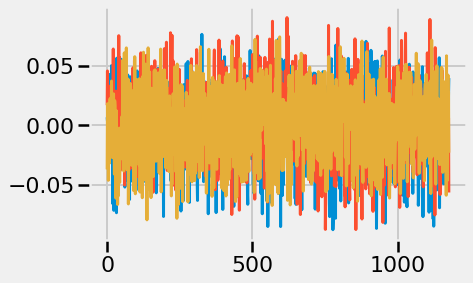

In [367]:
from sklearn.decomposition import FastICA

ica = FastICA(n_components=3)
S_ = ica.fit_transform(all_word_vectors_matrix)
print(S_)
fig = plt.figure()
plt.plot(S_)
plt.show()

In [368]:
idf = kmc(pd.DataFrame(S_), 2)

In [369]:
import numpy as np
from sklearn.random_projection import SparseRandomProjection
rng = np.random.RandomState(12)
X = all_word_vectors_matrix
transformer = SparseRandomProjection(random_state=rng, n_components=4)
X_new = transformer.fit_transform(X)

In [370]:
rdf = kmc(pd.DataFrame(X_new), 2)

In [344]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
X = all_word_vectors_matrix
y = df_out
clf = LinearDiscriminantAnalysis(n_components = 4)
clf.fit(X, y)
X_new = clf.fit_transform(X, y)

In [345]:
ldf = kmc(pd.DataFrame(X_new), 2)

In [402]:
#zoom in to some interesting places
def plot_region(x_bounds, y_bounds, points):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

In [407]:
def analyze_words(vecs):
    points =  pd.DataFrame(
    [
        (word, coords[0], coords[1], freq)
        for word, coords, freq in [
            (word, vecs[phys2vec.wv.vocab[word].index], phys2vec.wv.vocab[word].count)
            for word in phys2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y", "freq"]
    )
    
    sns.set_context("poster")
    
    points.plot.scatter("x", "y", s=10, figsize = (20, 12))
    
    plot_region(x_bounds=(1, 2), y_bounds=(1, 2), points = points)

In [434]:
analyze_words(all_words_matrix_2d)

NameError: name 'all_words_matrix_2d' is not defined

## Diabetes Neural Network (DNN)

In [149]:
import mlrose
import numpy as np
import nltk
import matplotlib.pyplot as plt
nltk.download('words')
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import validation_curve

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Karan\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [331]:
path = 'C:/Users/Karan/Desktop/OMSCS/CS7641/Assignment 2'
df = pd.read_csv(path + '/diabetes.csv')
df_out = df['Outcome']
df_features = df.drop('Outcome', axis = 1)

df_out.head(10)

0    1
1    0
2    1
3    0
4    1
5    0
6    1
7    0
8    1
9    1
Name: Outcome, dtype: int64

In [332]:
import pandas as pd
from sklearn import preprocessing

x = df_features
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_features_scaled = pd.DataFrame(x_scaled)
print(df_features_scaled.shape)

(768, 8)


In [153]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

def kmc(x, y, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters)
    kdf = kmeans.fit(x)
    
    correct = 0
    predictions = []
    for i in range(len(x)):
        predict_me = np.array(x.iloc[i].astype(float))
        predict_me = predict_me.reshape(-1, len(predict_me))
        prediction = kmeans.predict(predict_me)
        if prediction[0] == y[i]:
            correct += 1
        predictions.append(prediction)
        
    return predictions, correct/len(x)

In [176]:
from sklearn.decomposition import PCA

def PrinCA(x, y, n_components):
    pca = PCA(n_components=n_components)
    princX = pca.fit_transform(x)
    princX = pd.DataFrame(data = princX, columns = ['pc1', 'pc2'])
    princXY = pd.concat([princX, y], axis = 1)
    

    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('pc1', fontsize = 15)
    ax.set_ylabel('pc2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    targets = [0, 1]
    colors = ['r', 'g']
    for target, color in zip(targets,colors):
        indicesToKeep = princXY['Outcome'] == target
        ax.scatter(princXY.loc[indicesToKeep, 'pc1']
                   , princXY.loc[indicesToKeep, 'pc2']
                   , c = color
                   , s = 50)
    ax.legend(targets)
    ax.grid()
    
    return princX, princXY

In [177]:
p, a = kmc(df_features_scaled, df_out, 2)
print(len(p), len(df_features), p[4], a)

768 768 [0] 0.66796875


768 768 0    0.000000
1    0.688442
2    0.327869
3    0.353535
4    0.198582
5    0.642325
6    0.943638
7    0.200000
Name: 4, dtype: float64 0.6653645833333334


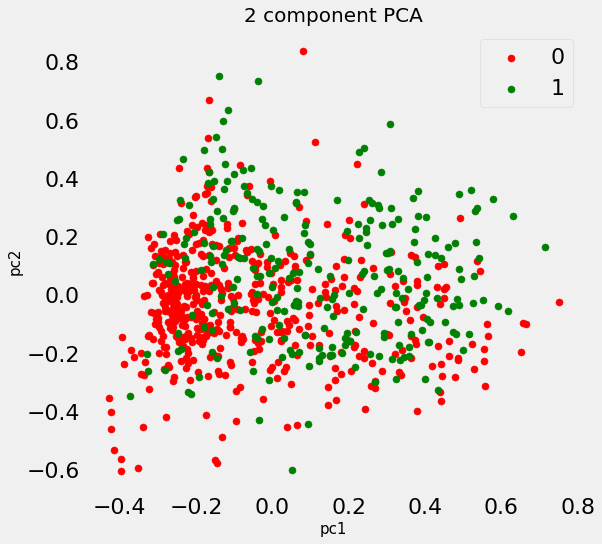

In [178]:
princX, princXY = PrinCA(df_features_scaled, df_out, 2)
p, a = kmc(princX, df_out, 2)
print(len(p), len(df_features), df_features_scaled.iloc[4], a)

[[ 0.04278839  0.02383968  0.01178097]
 [-0.03344269  0.02817331  0.00373875]
 [ 0.08301738  0.01412975 -0.03402874]
 ...
 [-0.00459341 -0.0092328   0.0042339 ]
 [ 0.01905912  0.02030595 -0.02526577]
 [-0.02511778  0.02832785  0.00908148]]


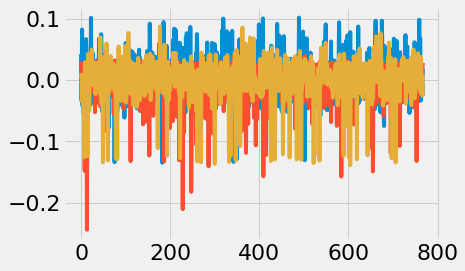

In [207]:
from sklearn.decomposition import FastICA

ica = FastICA(n_components=3)
S_ = ica.fit_transform(df_features)
print(S_)
fig = plt.figure()
plt.plot(S_)
plt.show()

In [208]:
p, a = kmc(pd.DataFrame(S_), df_out, 2)
print(a)

0.7200520833333334


In [147]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, max_iter=600, algorithm = 'auto')
kdf = kmeans.fit(principalDf)
print(kdf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


In [229]:
import numpy as np
from sklearn.random_projection import SparseRandomProjection
rng = np.random.RandomState(12)
X = df_features_scaled
transformer = SparseRandomProjection(random_state=rng, n_components=4)
X_new = transformer.fit_transform(X)

In [230]:
p, a = kmc(pd.DataFrame(X_new), df_out, 2)
print(a)

0.7005208333333334


In [252]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
X = df_features_scaled
y = df_out
clf = LinearDiscriminantAnalysis(n_components = 4)
clf.fit(X, y)
X_new = clf.fit_transform(X, y)

In [253]:
p, a = kmc(pd.DataFrame(X_new), df_out, 2)
print(a)

0.7682291666666666


In [148]:
correct = 0
predictions = []
for i in range(len(principalDf)):
    predict_me = np.array(principalDf.iloc[i].astype(float))
    predict_me = predict_me.reshape(-1, len(predict_me))
    prediction = kmeans.predict(predict_me)
    if prediction[0] == df_out[i]:
        correct += 1
    predictions.append(prediction)

print(correct/len(principalDf))

0.33984375


KeyError: False

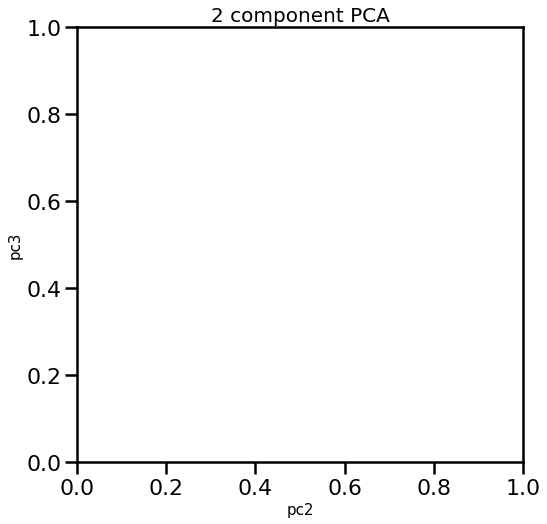

In [96]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('pc2', fontsize = 15)
ax.set_ylabel('pc3', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = predictions == target
    ax.scatter(finalDf.loc[indicesToKeep, 'pc2']
               , finalDf.loc[indicesToKeep, 'pc3']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

Converged: True
[[6.71716356e-21 0.00000000e+00 2.22673041e-06 4.75377512e-30
  9.99997773e-01]
 [7.09674526e-07 0.00000000e+00 3.90328617e-07 8.87526775e-32
  9.99998900e-01]
 [8.61831189e-13 0.00000000e+00 5.42128133e-10 6.12767331e-31
  9.99999999e-01]
 ...
 [9.29489448e-01 0.00000000e+00 7.05105363e-02 1.61779700e-08
  0.00000000e+00]
 [7.94177073e-23 0.00000000e+00 1.19968665e-10 6.12531775e-62
  1.00000000e+00]
 [6.66713938e-05 0.00000000e+00 2.60216415e-07 1.23290288e-24
  9.99933068e-01]]


ValueError: operands could not be broadcast together with shapes (589824,2) (8,) 

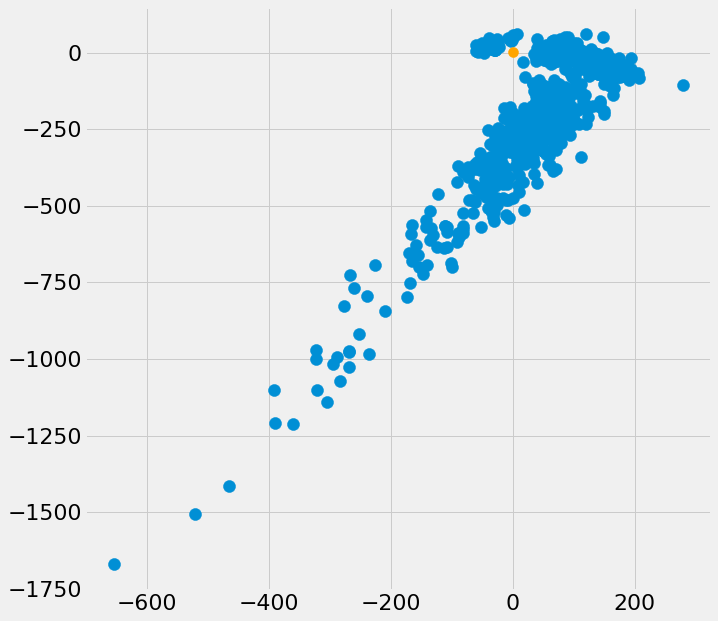

In [113]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
from sklearn.datasets.samples_generator import make_blobs
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture

# 0. Create dataset
X = np.array(df_features)
Y = np.array(df_features)

# Stratch dataset to get ellipsoid data
X = np.dot(X,np.random.RandomState(0).randn(8,8))

x,y = np.meshgrid(np.sort(X[:,0]),np.sort(X[:,1]))
XY = np.array([x.flatten(),y.flatten()]).T

GMM = GaussianMixture(n_components=5).fit(X) # Instantiate and fit the model
print('Converged:',GMM.converged_) # Check if the model has converged
means = GMM.means_ 
covariances = GMM.covariances_


# Predict
Y = np.array([[0.5],[0.5]])
prediction = GMM.predict_proba(X)
print(prediction)

# Plot   
fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)
ax0.scatter(X[:,0],X[:,1])
ax0.scatter(Y[0,:],Y[1,:],c='orange',zorder=10,s=100)
for m,c in zip(means,covariances):
    multi_normal = multivariate_normal(mean=m,cov=c)
    ax0.contour(np.sort(X[:,0]),np.sort(X[:,1]),multi_normal.pdf(XY).reshape(len(X),len(X)),colors='black',alpha=0.3)
    ax0.scatter(m[0],m[1],c='grey',zorder=10,s=100)
    
plt.show()

In [64]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(df_features)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2', 'pc3'])
finalDf = pd.concat([principalDf, df_out], axis = 1)
print(finalDf)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('pc2', fontsize = 15)
ax.set_ylabel('pc3', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Outcome'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'pc2']
               , finalDf.loc[indicesToKeep, 'pc3']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [66]:
finalDf = pd.concat([principalDf, df_out], axis = 1)
print(finalDf)

            pc1        pc2        pc3  Outcome
0    -75.714655 -35.950783  -7.260789        1
1    -82.358268  28.908213  -5.496671        0
2    -74.630643 -67.906496  19.461808        1
3     11.077423  34.898486  -0.053018        0
4     89.743788  -2.746937  25.212859        1
5    -80.977922  -3.946887   0.641395        0
6      4.350959  46.933912   9.183418        1
7    -82.137294   7.097954  67.488999        0
8    468.866389 -31.528258  10.057072        1
9    -80.193850 -18.048283 -18.049763        1
10   -81.104970  -1.209014 -18.390450        0
11   -75.742173 -55.758466   5.843019        1
12   -78.716372 -31.128432  -5.293599        0
13   767.474062   4.267684  30.567287        1
14    98.757395 -37.567773   4.834268        1
15   -83.683166  21.577218  65.730332        1
16   150.939440  16.197164 -20.589987        1
17   -81.809763   4.429602  -1.349660        1
18     2.024762  23.827289  26.809238        0
19    16.148467   7.800201  -4.361995        1
20   156.3045

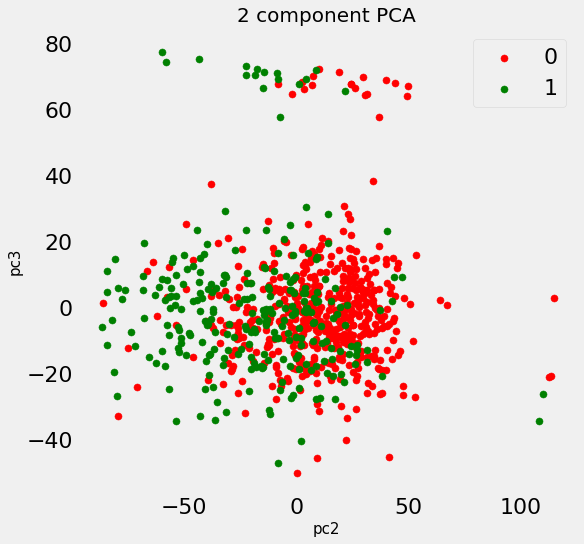

In [128]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('pc2', fontsize = 15)
ax.set_ylabel('pc3', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Outcome'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'pc2']
               , finalDf.loc[indicesToKeep, 'pc3']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

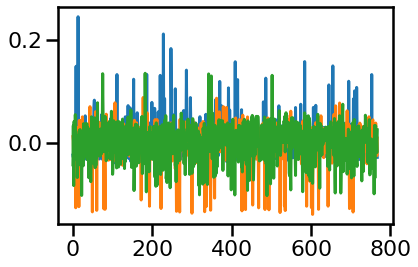

In [85]:
from sklearn.decomposition import FastICA

ica = FastICA(n_components=3)
S_ = ica.fit_transform(df_features)
fig = plt.figure()
plt.plot(S_)
plt.show()    


In [303]:
path = 'C:/Users/Karan/Desktop/OMSCS/CS7641/Assignment 3'
df_features = pd.read_csv(path + '/train.csv')
df_features = df_features[df_features['ConfirmedCases'] != 0]
df_out = df_features['ConfirmedCases']
df_features = df_features.drop('ConfirmedCases', axis = 1)
df_features = df_features.drop('Fatalities', axis = 1)
df_features = df_features.drop('Id', axis = 1)
df_features = df_features.drop('Province/State', axis = 1)
df_features = df_features.drop('Country/Region', axis = 1)
df_features = df_features.drop('Start Date', axis = 1)
df_features = df_features.drop('Date', axis = 1)

df_out.head(10)

33    1
34    1
35    1
36    1
37    1
38    1
39    1
40    1
41    1
42    1
Name: ConfirmedCases, dtype: int64

In [304]:
import pandas as pd
from sklearn import preprocessing

x = df_features
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_features_scaled = pd.DataFrame(x_scaled)

In [316]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

def kmc(x, y, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters)
    kdf = kmeans.fit(x)
    
    correct = 0
    predictions = []
    y = np.round(n_clusters*(y/np.max(y)))
    for i in range(len(x)):
        
        predict_me = np.array(x.iloc[i].astype(float))
        predict_me = predict_me.reshape(-1, len(predict_me))
        prediction = kmeans.predict(predict_me)
        predicted = np.round(n_clusters*(prediction[0]/np.max(y)))
        if predicted == y.iloc[i]:
            correct += 1
        predictions.append(prediction)
        
    return predictions, correct/len(x)

In [317]:
from sklearn.decomposition import PCA

def PrinCA(x, y, n_components):
    pca = PCA(n_components=n_components)
    princX = pca.fit_transform(x)
    princX = pd.DataFrame(data = princX, columns = ['pc1', 'pc2'])
    princXY = pd.concat([princX, y], axis = 1)
    
    return princX, princXY

In [324]:
p, a = kmc(df_features, df_out, 10)
print(len(p), len(df_features), a)

6429 6429 0.06735106548452326


In [323]:
princX, princXY = PrinCA(df_features, df_out, 2)
p, a = kmc(princX, df_out, 10)
print(len(p), len(df_features), df_features.iloc[4], a)

6429 6429 Lat         33.0
Long        65.0
DateVal    103.0
Name: 37, dtype: float64 0.10063773526209364


[[-0.00659254 -0.01294543 -0.00149317]
 [-0.00659254 -0.01251391 -0.00149317]
 [-0.00659254 -0.0120824  -0.00149317]
 ...
 [ 0.00241464  0.0120824   0.01363071]
 [ 0.00241464  0.01251391  0.01363071]
 [ 0.00241464  0.01294543  0.01363071]]


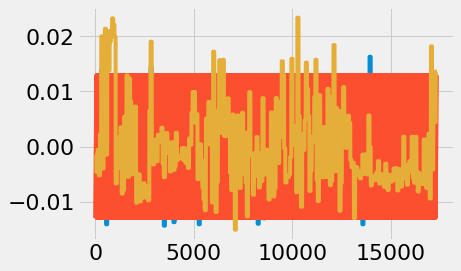

In [284]:
from sklearn.decomposition import FastICA

ica = FastICA(n_components=3)
S_ = ica.fit_transform(df_features)
print(S_)
fig = plt.figure()
plt.plot(S_)
plt.show()

In [285]:
p, a = kmc(pd.DataFrame(S_), df_out, 2)
print(a)

0.24959593627337798


In [286]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, max_iter=600, algorithm = 'auto')
kdf = kmeans.fit(principalDf)
print(kdf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


In [287]:
import numpy as np
from sklearn.random_projection import SparseRandomProjection
rng = np.random.RandomState(12)
X = df_features_scaled
transformer = SparseRandomProjection(random_state=rng, n_components=4)
X_new = transformer.fit_transform(X)

C:\Users\Karan\Anaconda3\lib\site-packages\sklearn\random_projection.py:378: DataDimensionalityWarning:

The number of components is higher than the number of features: n_features < n_components (3 < 4).The dimensionality of the problem will not be reduced.



In [288]:
p, a = kmc(pd.DataFrame(X_new), df_out, 2)
print(a)

0.4427961209882244


In [291]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
X = df_features_scaled
y = df_out
clf = LinearDiscriminantAnalysis(n_components = 2)
clf.fit(X, y)
X_new = clf.fit_transform(X, y)

In [294]:
p, a = kmc(pd.DataFrame(X_new), df_out, 5)
print(p, a)

[array([4]), array([4]), array([4]), array([4]), array([4]), array([4]), array([4]), array([4]), array([4]), array([4]), array([4]), array([4]), array([4]), array([4]), array([4]), array([4]), array([4]), array([4]), array([4]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([4]), array([4]), array([4]), array([4]), array([4]), array([4]), array([4]), array([4]), array([4]), array([4]), array([4]), array([4]), array([4]), array([4]), array([4]), array([4]), array([4]), array([4]), array([4]), array([4]), array([2]), array([2]), arr

In [428]:
from sklearn import mixture

def EMax(X, Y, n_components):

    clf = mixture.GaussianMixture(n_components=n_components)
    clf.fit(X, Y)
    s = clf.predict(X)
    a = 1-np.sum(abs(s-np.array(Y)))/len(Y)
    return a

In [429]:
princX, princXY = PrinCA(df_features_scaled, 2)
a = EMax(princX, df_out, 2)
print(a)

ValueError: could not convert string to float: 'pc1'

[[ 0.04278839  0.02383968  0.01178097]
 [-0.03344269  0.02817331  0.00373875]
 [ 0.08301738  0.01412975 -0.03402874]
 ...
 [-0.00459341 -0.0092328   0.0042339 ]
 [ 0.01905912  0.02030595 -0.02526577]
 [-0.02511778  0.02832785  0.00908148]]


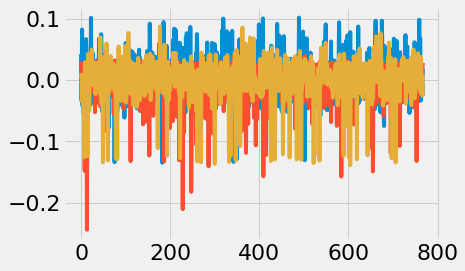

In [207]:
from sklearn.decomposition import FastICA

ica = FastICA(n_components=3)
S_ = ica.fit_transform(df_features)
print(S_)
fig = plt.figure()
plt.plot(S_)
plt.show()

In [208]:
p, a = kmc(pd.DataFrame(S_), df_out, 2)
print(a)

0.7200520833333334


In [147]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, max_iter=600, algorithm = 'auto')
kdf = kmeans.fit(principalDf)
print(kdf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


In [229]:
import numpy as np
from sklearn.random_projection import SparseRandomProjection
rng = np.random.RandomState(12)
X = df_features_scaled
transformer = SparseRandomProjection(random_state=rng, n_components=4)
X_new = transformer.fit_transform(X)

In [230]:
p, a = kmc(pd.DataFrame(X_new), df_out, 2)
print(a)

0.7005208333333334


In [252]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
X = df_features_scaled
y = df_out
clf = LinearDiscriminantAnalysis(n_components = 4)
clf.fit(X, y)
X_new = clf.fit_transform(X, y)

In [253]:
p, a = kmc(pd.DataFrame(X_new), df_out, 2)
print(a)

0.7682291666666666


In [ ]:
p = 
i
r
l

print(pdf, idf, rdf, ldf)